In [2]:
import numpy as np
from pydpmd.data import RigidBumpy, load, BaseParticle
from pydpmd.data.bumpy_utils import get_closest_vertex_radius_for_mu_eff
from pydpmd.utils import join_systems, split_systems
from pydpmd.plot import draw_particles_frame
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from matplotlib.colors import LogNorm
import pickle

def get_angular_extent(clustered_angles):
    # assumes that the angles form a continuous cluster and are normalized to [0, 2pi)
    # finds the total angular extent of the cluster
    s = np.sort(clustered_angles)
    gaps = np.diff(np.r_[s, s[0] + 2*np.pi])  # get the gaps between the sorted angles and the first angle plus 2pi
    return 2*np.pi - np.max(gaps)  # get the total extent of the cluster

def get_translational_extent(clustered_pos):
    return np.linalg.norm(np.max(clustered_pos, axis=0) - np.min(clustered_pos, axis=0), axis=-1)

In [3]:
# make rigid bumpy with core

# get right energy scale

# implement a real monte carlo scheme

In [4]:
phi_js = {}
for mu_eff in mu_effs:
    data_root = f"/home/mmccraw/dev/data/09-09-25/box-sample/bumpy/{mu_eff}"
    jam_data = load(os.path.join(data_root, "jam"), location=["final"])
    phi_js[mu_eff] = np.max(jam_data.packing_fraction)

NameError: name 'mu_effs' is not defined

In [5]:
# load all the data
# for each delta_phi in each dataset, determine the number, fraction, and coordinates of the free volume
# for each delta_phi, pick the domain size that has the largest free fraction less than 0.1
# (i.e. domain is adequately sized)

mu_effs = [0.01, 0.05, 0.1, 0.5]

pickle_path = '/home/mmccraw/dev/data/09-09-25/box-sample/bumpy-data-aggregated.pkl'
if os.path.exists(pickle_path):
    with open(pickle_path, 'rb') as f:
        datasets = pickle.load(f)
else:
    datasets = {mu: {
        'free_volume': [],
        'free_fraction': [],
        'free_count': [],
        'pos': [],
        'angle': [],
        'delta_phi': [],
    } for mu in mu_effs}

    for mu_eff in mu_effs:
        data_root = f"/home/mmccraw/dev/data/09-09-25/box-sample/bumpy/{mu_eff}"

        free_volume = {}
        free_fraction = {}
        pos = {}
        angle = {}
        delta_phi = {}

        # for suffix in ["", "-mid", "-mid-1", "-mid-2", "-mid-3", "-mid-4", "-mid-5", "-mid-6", "-mid-7"]:
        for suffix in ["", "-mid", "-mid-1", "-mid-2", "-mid-6", "-mid-7", "-mid-8"]:
            box_sample_data_path = os.path.join(data_root, f"box-sample{suffix}")
            data = load(box_sample_data_path, location=["init"], load_trajectory=True)
            domain_area = np.load(os.path.join(box_sample_data_path, "domain_area.npy"))

            if len(free_volume.keys()) == 0:
                free_volume = {dp: [] for dp in np.unique(data.delta_phi)}
                free_fraction = {dp: [] for dp in np.unique(data.delta_phi)}
                pos = {dp: [] for dp in np.unique(data.delta_phi)}
                angle = {dp: [] for dp in np.unique(data.delta_phi)}
                delta_phi = {dp: [] for dp in np.unique(data.delta_phi)}

            # calculate the total hypervolume of the combined sampling domain
            ap = data.angular_period[:2].copy()
            ap[ap == 0] = 1
            
            valid_mask = data.trajectory.pe_total == 0
            for _delta_phi in tqdm(np.unique(data.delta_phi)):
                duplicate_mask = data.delta_phi == _delta_phi
                frac = np.mean(valid_mask[:, duplicate_mask])
                free_fraction[_delta_phi].append(frac)
                duplicate_particle_mask = duplicate_mask[data.system_id]
                domain_hypervolume = np.prod(domain_area[duplicate_particle_mask][:2].copy()) * np.prod(ap)
                free_volume[_delta_phi].append(frac * domain_hypervolume)
                valid_particle_mask = valid_mask[:, data.system_id][:, duplicate_particle_mask]
                pos[_delta_phi].append(data.trajectory.pos[:, duplicate_particle_mask][valid_particle_mask, :])
                angle[_delta_phi].append(data.trajectory.angle[:, duplicate_particle_mask][valid_particle_mask])
                delta_phi[_delta_phi].append(_delta_phi)
        
        # unify the values:
        # pick the dataset with the largest free_fraction LESS than 0.1
        for dp in delta_phi.keys():
            mask = (np.array(free_fraction[dp]) < 0.01) & (np.array(free_fraction[dp]) > 0.0)
            if not np.any(mask):
                continue
            max_frac = np.max(np.array(free_fraction[dp])[mask])
            i = np.where(np.array(free_fraction[dp]) == max_frac)[0][0]
            datasets[mu_eff]['free_volume'].append(free_volume[dp][i])
            datasets[mu_eff]['free_fraction'].append(free_fraction[dp][i])
            datasets[mu_eff]['pos'].append(pos[dp][i])
            datasets[mu_eff]['angle'].append(angle[dp][i])
            datasets[mu_eff]['delta_phi'].append(delta_phi[dp][i])
            datasets[mu_eff]['free_count'].append(datasets[mu_eff]['pos'][-1].shape[0])

        datasets[mu_eff]['free_volume'] = np.array(datasets[mu_eff]['free_volume'])
        datasets[mu_eff]['free_fraction'] = np.array(datasets[mu_eff]['free_fraction'])
        datasets[mu_eff]['free_count'] = np.array(datasets[mu_eff]['free_count'])
        datasets[mu_eff]['delta_phi'] = np.array(datasets[mu_eff]['delta_phi'])

    with open(pickle_path, 'wb') as f:
        pickle.dump(datasets, f)

In [6]:
large_box_pickle_path = '/home/mmccraw/dev/data/09-09-25/box-sample/bumpy-data-large-box.pkl'
if os.path.exists(large_box_pickle_path):
    with open(large_box_pickle_path, 'rb') as f:
        large_box_datasets = pickle.load(f)
else:
    large_box_datasets = {mu: {
        'free_volume': [],
        'free_fraction': [],
        'free_count': [],
        'pos': [],
        'angle': [],
        'delta_phi': [],
    } for mu in mu_effs}

    for mu_eff in mu_effs:
        data_root = f"/home/mmccraw/dev/data/09-09-25/box-sample/bumpy/{mu_eff}"

        free_volume = {}
        free_fraction = {}
        pos = {}
        angle = {}
        delta_phi = {}

        box_sample_data_path = os.path.join(data_root, f"box-sample-large-box")
        data = load(box_sample_data_path, location=["init"], load_trajectory=True)
        domain_area = np.load(os.path.join(box_sample_data_path, "domain_area.npy"))

        if len(free_volume.keys()) == 0:
            free_volume = {dp: [] for dp in np.unique(data.delta_phi)}
            free_fraction = {dp: [] for dp in np.unique(data.delta_phi)}
            pos = {dp: [] for dp in np.unique(data.delta_phi)}
            angle = {dp: [] for dp in np.unique(data.delta_phi)}
            delta_phi = {dp: [] for dp in np.unique(data.delta_phi)}

        # calculate the total hypervolume of the combined sampling domain
        ap = data.angular_period[:2].copy()
        ap[ap == 0] = 1
        
        valid_mask = data.trajectory.pe_total == 0
        for _delta_phi in tqdm(np.unique(data.delta_phi)):
            duplicate_mask = data.delta_phi == _delta_phi
            frac = np.mean(valid_mask[:, duplicate_mask])
            duplicate_particle_mask = duplicate_mask[data.system_id]
            free_fraction[_delta_phi].append(frac)
            domain_hypervolume = np.prod(domain_area[duplicate_particle_mask][:2].copy()) * np.prod(ap)
            free_volume[_delta_phi].append(frac * domain_hypervolume)
            valid_particle_mask = valid_mask[:, data.system_id][:, duplicate_particle_mask]
            pos[_delta_phi].append(data.trajectory.pos[:, duplicate_particle_mask][valid_particle_mask, :])
            angle[_delta_phi].append(data.trajectory.angle[:, duplicate_particle_mask][valid_particle_mask])
            delta_phi[_delta_phi].append(_delta_phi)
        large_box_datasets[mu_eff]['free_volume'] = np.array(list(free_volume.values())).squeeze()
        large_box_datasets[mu_eff]['free_fraction'] = np.array(list(free_fraction.values())).squeeze()
        large_box_datasets[mu_eff]['pos'] = [p[0] for p in pos.values()]
        large_box_datasets[mu_eff]['angle'] = [a[0] for a in angle.values()]
        large_box_datasets[mu_eff]['delta_phi'] = np.array(list(delta_phi.values())).squeeze()
    with open(large_box_pickle_path, 'wb') as f:
        pickle.dump(large_box_datasets, f)

4.930251748897996
5.102043375746203
5.066727910108655
5.01679634456266


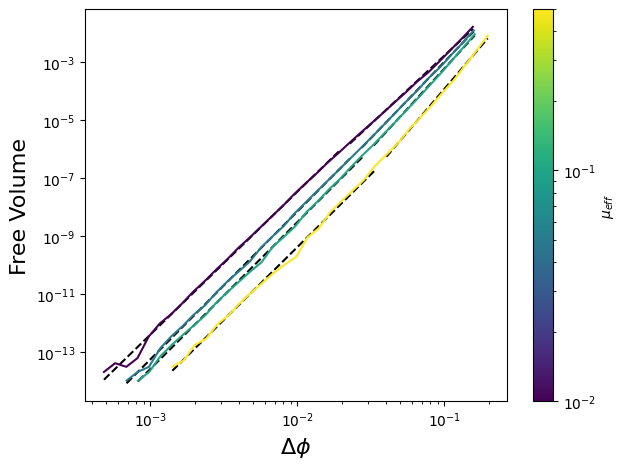

In [7]:
norm = LogNorm(vmin=min(mu_effs), vmax=max(mu_effs))
cmap = plt.cm.viridis
for mu_eff, ds in datasets.items():
    plt.plot(ds['delta_phi'], ds['free_volume'], c=cmap(norm(mu_eff)))
    x = np.log10(ds['delta_phi'])
    y = np.log10(ds['free_volume'])

    mk = (x < x.min() / 2)
    m, b = np.polyfit(x[mk], y[mk], 1)
    plt.plot(10 ** x[mk], 10 ** (m*x[mk] + b), c='k', zorder=0, linestyle='--')
    print(m)

    mk = (x > x.min() / 2)
    m, b = np.polyfit(x[mk], y[mk], 1)
    plt.plot(10 ** x[mk], 10 ** (m*x[mk] + b), c='k', zorder=0, linestyle='--')

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\Delta \phi$", fontsize=16)
plt.ylabel(r"Free Volume", fontsize=16)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array(mu_eff)
cbar = plt.colorbar(sm, ax=plt.gca(), label=r'$\mu_{eff}$')
plt.tight_layout()
plt.savefig("figures/free_volume.png", dpi=300)
plt.show()


In [8]:
norm = LogNorm(vmin=min(mu_effs), vmax=max(mu_effs))
cmap = plt.cm.viridis
for mu_eff, ds in datasets.items():
    x = np.log10(phi_js[mu_eff] - ds['delta_phi'])
    y = np.log10(ds['free_volume'])

    plt.plot(x, y, c=cmap(norm(mu_eff)))

    mk = (x < x.min() / 2)
    m, b = np.polyfit(x[mk], y[mk], 1)

    x_large = np.log10(phi_js[mu_eff] - large_box_datasets[mu_eff]['delta_phi'])
    y_large = np.log10(large_box_datasets[mu_eff]['free_volume'])

    plt.plot(x_large, y_large, c=cmap(norm(mu_eff)))

# plt.xscale("log")
# plt.yscale("log")
# plt.xlabel(r"$\Delta \phi$", fontsize=16)
# plt.ylabel(r"Free Volume", fontsize=16)
# sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
# sm.set_array(mu_eff)
# cbar = plt.colorbar(sm, ax=plt.gca(), label=r'$\mu_{eff}$')
# plt.tight_layout()
# plt.savefig("figures/free_volume.png", dpi=300)
# plt.show()


KeyError: 0.01

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

1.0164358598490726 0.6161555288806289
1.0485328457438394 0.6523393734464134
1.0769590623722407 0.6733803334249686
1.0461821425163338 0.4542210219771164


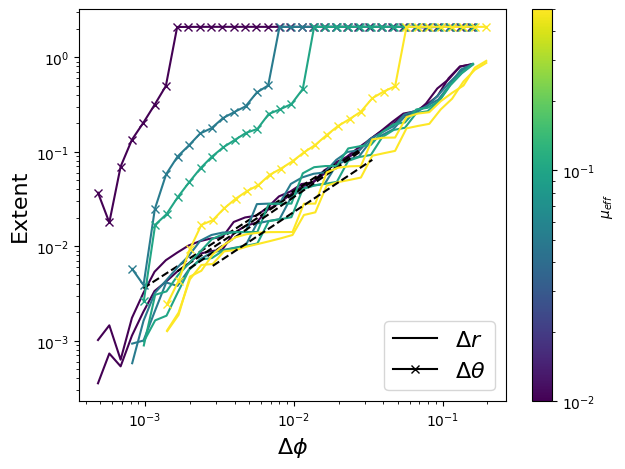

In [36]:
for mu_eff, ds in datasets.items():
    trans_ext = np.array([get_translational_extent(np.stack(([ds['pos'][i][0::2], ds['pos'][i][1::2]]), axis=1)) for i in range(len(ds['pos']))])
    ang_ext = np.array([get_angular_extent(ds['angle'][i][0::2]) for i in range(len(ds['angle']))])
    m = np.all(trans_ext > 0, axis=1)
    plt.plot(ds['delta_phi'][m], trans_ext[m], c=cmap(norm(mu_eff)))
    plt.plot(ds['delta_phi'][m], ang_ext[m], c=cmap(norm(mu_eff)), marker='x')

    x = np.log10(ds['delta_phi'][m])
    y = np.log10(np.mean(trans_ext[m], axis=1))
    plt.plot(x, y)
    m2 = (x < x.min() / 2) & (x > x.min() / 1.1)
    x = x[m2]
    y = y[m2]
    m, b = np.polyfit(x, y, 1)
    plt.plot(10 ** x, 10 ** (m*x + b), c='k', linestyle='--')
    print(m, b)


plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\Delta \phi$", fontsize=16)
plt.ylabel(r"Extent", fontsize=16)
plt.plot([], [], c='k', label=r'$\Delta r$')
plt.plot([], [], c='k', marker='x', label=r'$\Delta \theta$')
plt.legend(fontsize=16)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array(mu_eff)
cbar = plt.colorbar(sm, ax=plt.gca(), label=r'$\mu_{eff}$')
plt.tight_layout()
plt.savefig("figures/extents.png", dpi=300)
plt.show()

In [ ]:
# import pickle
# with open('/home/mmccraw/dev/data/09-09-25/box-sample/bumpy-data-aggregated.pkl', 'wb') as f:
#     pickle.dump(datasets, f)